In [54]:
import gymnasium as gym
import torch
import random
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the CartPole environment
env = gym.make('CartPole-v1')

# Set seeds for reproducibility
env.reset(seed=0)
env.action_space.seed(0)
env.observation_space.seed(0)
np.random.seed(0)
torch.manual_seed(0)


In [55]:
# Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed) # Set the random seed for reproducibility
        self.fc1 = nn.Linear(state_size, 64) # first layer that maps from state_size to 64 units
        self.fc2 = nn.Linear(64, 64) # second layer that maps from 64 units to another 64 units
        self.fc3 = nn.Linear(64, action_size) # final layer that maps from 64 units to action_size (output layer)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x) 


In [56]:
# Define the Replay Buffer
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        
        # Initialize the memory as a deque to store experiences with a maximum length of buffer_size
        self.memory = deque(maxlen=buffer_size)
        
        # Set the size of each training batch
        self.batch_size = batch_size
        
        # Define the experience tuple that will store state, action, reward, next_state, and done flag
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
        # Set the random seed for reproducibility
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        # Create a new experience tuple
        e = self.experience(state, action, reward, next_state, done)
        
        # Add the experience to the memory buffer
        self.memory.append(e)

    def sample(self):
        # Randomly sample a batch of experiences from the memory buffer
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # Convert the list of experiences into a batch of states, actions, rewards, next_states, and dones
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        # Return the sampled batch of experiences as a tuple
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory) # Return the current size of the internal memory.


In [57]:
# Define the DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size, seed, buffer_size=10000, batch_size=64, gamma=0.99, lr=0.001, update_every=4, tau=1e-3):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.gamma = gamma  # Discount factor
        self.batch_size = batch_size
        self.update_every = update_every  # Frequency of network updates
        self.tau = tau  # For soft update of target network

        # Q-Networks
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)  # Local Q-Network
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)  # Target Q-Network
        self.optimizer = Adam(self.qnetwork_local.parameters(), lr=lr)  # Optimizer for the local Q-Network

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        self.t_step = 0  # Initialize time step for updating the network

    def step(self, state, action, reward, next_state, done):
        # Save the experience in the replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Increment the time step
        self.t_step = (self.t_step + 1) % self.update_every
        
        # Learn every update_every time steps
        if self.t_step == 0 and len(self.memory) > self.batch_size:
            experiences = self.memory.sample()  # Sample a batch of experiences from memory
            self.learn(experiences, self.gamma)  # Learn from the sampled experiences

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)  # Convert state to torch tensor and add batch dimension
        self.qnetwork_local.eval()  # Set local network to evaluation mode
        with torch.no_grad():
            action_values = self.qnetwork_local(state)  # Get action values from the network
        self.qnetwork_local.train()  # Set local network back to training mode
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())  # Exploit: choose action with highest value
        else:
            return random.choice(np.arange(self.action_size))  # Explore: choose a random action

    def learn(self, experiences, gamma):
        # Update the value parameters using a batch of experience tuples.
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss
        loss = torch.nn.functional.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update of target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        """
            Soft update model parameters.
            θ_target = τ*θ_local + (1 - τ)*θ_target
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


In [58]:
# Initialize the agent
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size, seed=0)

In [59]:
# Updated Training Loop
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes + 1):
        state = env.reset()
        state = state[0]  # Extract the state array from the tuple
        state = np.array(state)  # Convert state to NumPy array
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, truncated, _ = env.step(action)  # Unpack all return values
            next_state = np.array(next_state)  # Convert next_state to NumPy array
            agent.step(state, action, reward, next_state, done or truncated)  # Consider episode done if done or truncated
            state = next_state
            score += reward
            if done or truncated:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)
        if i_episode % 100 == 0:
            print(f'Episode {i_episode}\tAverage Score: {np.mean(scores_window)}')
        if np.mean(scores_window) >= 195.0:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {np.mean(scores_window)}')
            torch.save(agent.qnetwork_local.state_dict(), 'model/checkpoint.pth')
            break
    return scores


Episode 100	Average Score: 15.86
Episode 200	Average Score: 12.06
Episode 300	Average Score: 10.85
Episode 400	Average Score: 10.43
Episode 500	Average Score: 10.01
Episode 600	Average Score: 10.1
Episode 700	Average Score: 11.08
Episode 800	Average Score: 13.61
Episode 900	Average Score: 17.68
Episode 1000	Average Score: 179.18

Environment solved in 1008 episodes!	Average Score: 195.04


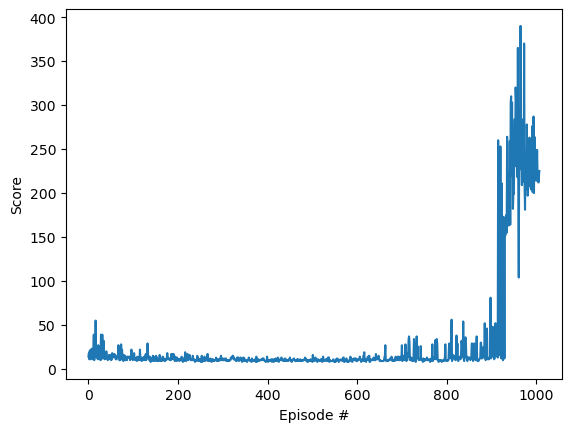

In [60]:
scores = dqn()

# Plot the scores
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()